In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
structures = pd.read_csv('../../data/structures.csv')
structures.atom.unique()

array(['C', 'H', 'N', 'O', 'F'], dtype=object)

In [4]:
import os

class util:
    @staticmethod
    def mkdirs(paths):
        if isinstance(paths, list) and not isinstance(paths, str):
            for path in paths:
                util.mkdir(path)
        else:
            util.mkdir(paths)

    @staticmethod
    def mkdir(path):
        if not os.path.exists(path):
            os.makedirs(path)

In [5]:
# options
import argparse
import os
import torch

class BaseOptions:
    def __init__(self):
        self.parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
        self.initialized = False
    
    def initialize(self):
        self.parser.add_argument('--dataroot', required=True, help='path to csv files')
        self.parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
        self.parser.add_argument('--checkpoints_dir', default='./checkpoints', help='models are saved here')
        self.parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        self.parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        self.parser.add_argument('--nThreads', default=6, type=int, help='# threads for loading data')
        self.parser.add_argument('--max_dataset_size', type=int, default=float("inf"),
                                 help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        self.parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        self.parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal|xavier|kaiming|orthogonal]')
        self.parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization')

        # custom
        self.parser.add_argument('--atomtypes', type=str, default='element',
                                 help='atom typing policy. [element]')
        self.parser.add_argument('--model', type=str, default='simple',
                                 help='chooses which model to use. [simple]')
        self.parser.add_argument('--grid_size', type=float, default=24, help='size of grid (angstrom)')
        self.parser.add_argument('--grid_spacing', type=float, default=1.0, help='spacing of grid')
        self.parser.add_argument('--grid_func', type=str, help='atom density function')
        self.parser.add_argument('--rotate', type=float, default=180, help='random rotation of dataset')
        self.initialized = True

    def parse(self, args=None):
        if not self.initialized:
            self.initialize()
        self.opt = self.parser.parse_args(args)
        self.opt.isTrain = self.isTrain
        
        str_ids = self.opt.gpu_ids.split(',')
        self.opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                self.opt.gpu_ids.append(id)

        # set gpu ids
        if len(self.opt.gpu_ids) > 0:
            torch.cuda.set_device(self.opt.gpu_ids[0])
            
        # input channel
        if self.opt.atomtypes == 'element':
            self.opt.input_nc = 5
        
        self.opt.nx, self.opt.ny, self.opt.nz = [int(self.opt.grid_size/self.opt.grid_spacing) for _ in range(3)]
        if self.opt.nx % 2 == 0: self.opt.nx += 1
        if self.opt.ny % 2 == 0: self.opt.ny += 1
        if self.opt.nz % 2 == 0: self.opt.nz += 1
            
        args = vars(self.opt)

        print('------------ Options -------------')
        for k, v in sorted(args.items()):
            print('%s: %s' % (str(k), str(v)))
        print('-------------- End ----------------')
        
        # save to the disk
        expr_dir = os.path.join(self.opt.checkpoints_dir, self.opt.name)
        util.mkdirs(expr_dir)
        file_name = os.path.join(expr_dir, 'opt.txt')
        with open(file_name, 'wt') as opt_file:
            opt_file.write('------------ Options -------------\n')
            for k, v in sorted(args.items()):
                opt_file.write('%s: %s\n' % (str(k), str(v)))
            opt_file.write('-------------- End ----------------\n')
        return self.opt

class TrainOptions(BaseOptions):
    def initialize(self):
        BaseOptions.initialize(self)
        self.parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        self.parser.add_argument('--optimizer', type=str, default='adam', help='optimizer [sgd|adam]')
        self.parser.add_argument('--momentum', type=float, default=0.9, help='momentum term')
        self.parser.add_argument('--beta1', type=float, default=0.9, help='momentum term of adam')
        self.parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
        self.parser.add_argument('--lr_policy', type=str, default='lambda', help='learning rate policy: lambda|step|plateau')
        self.parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')
        self.parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        self.parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        self.parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate')
        self.parser.add_argument('--niter_decay', type=int, default=100, help='# of iter to linearly decay learning rate to zero')
        self.parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
        self.parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
        self.parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
        self.isTrain = True

class TestOptions(BaseOptions):
    def initialize(self):
        BaseOptions.initialize(self)
        self.parser.add_argument('--phase', type=str, default='test', help='train, val, test, etc')
        self.parser.add_argument('--which_epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        self.isTrain = False
        
opt = TrainOptions().parse('--dataroot ../../data --grid_size 9.6 --grid_spacing 0.2 \
                            --batch_size 8 --rotate 0 \
                            --max_dataset_size 153353 --nThreads 4 \
                            --lr 0.0001 --optimizer adam \
                            --niter 3 --niter_decay 3'.split())

------------ Options -------------
atomtypes: element
batch_size: 8
beta1: 0.9
checkpoints_dir: ./checkpoints
continue_train: False
dataroot: ../../data
epoch_count: 1
gpu_ids: [0]
grid_func: None
grid_size: 9.6
grid_spacing: 0.2
init_type: normal
input_nc: 5
isTrain: True
lr: 0.0001
lr_decay_iters: 50
lr_policy: lambda
max_dataset_size: 153353
model: simple
momentum: 0.9
nThreads: 4
name: experiment_name
niter: 3
niter_decay: 3
norm: instance
nx: 47
ny: 47
nz: 47
optimizer: adam
phase: train
print_freq: 100
rotate: 0.0
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
-------------- End ----------------


(47, 47, 47)
-4.612698136270047 -3.514195895195008 -4.591999004036189


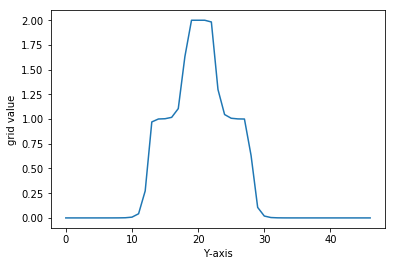

In [6]:
import numba
from math import exp, sqrt, cos, sin, e

@numba.jit('f4[:,:,:](f4[:,:], f4[:,:,:], i8, i8, i8, f8, f8, f8, f8, f8)', nopython=True)
def coords_to_grid_numba(coords, grid, nx, ny, nz, xmin, ymin, zmin, spacing, rvdw):
    exps = 0.01
    rmax = 20
    #expt = np.exp(-(rvdw/np.arange(0,rmax,exps))**12)
    expt = np.exp(-(rvdw/np.arange(0,rmax,exps))**12)
    nc = len(coords)
    for i in range(nx):
        ix = xmin + i*spacing
        for j in range(ny):
            iy = ymin + j*spacing
            for k in range(nz):
                iz = zmin + k*spacing
                for l in range(nc):
                    dx = ix - coords[l,0]
                    dy = iy - coords[l,1]
                    dz = iz - coords[l,2]
                    r = sqrt(dx*dx + dy*dy + dz*dz)
                    #grid[i,j,k] += 1 - exp(-(rvdw/r)**12)
                    if r > rmax: continue
                    grid[i,j,k] += 1 - expt[int(r/exps)]
    return grid

nx = ny = nz = int(opt.grid_size / opt.grid_spacing)
if nx % 2 == 0: nx += 1
if ny % 2 == 0: ny += 1
if nz % 2 == 0: nz += 1
grid = np.zeros((nx, ny, nz), dtype=np.float32)
print(grid.shape)
coords = np.array(((-0.012698135900000001, 1.085804158, 0.008000995799999999),
                   ( 2.15041600e-03, -6.03131760e-03,  1.97612040e-03)), dtype=np.float32)
spacing = opt.grid_spacing
xmin = coords[0][0] - (nx-1)/2*spacing
ymin = coords[0][1] - (ny-1)/2*spacing
zmin = coords[0][2] - (nz-1)/2*spacing
print(xmin, ymin, zmin)
rvdw = 1
grid = coords_to_grid_numba(coords, grid, nx, ny, nz, xmin, ymin, zmin, spacing, rvdw)

x = np.arange(nx)
y = grid[int((nx-1)/2), :, int((nx-1)/2)]
plt.xlabel('Y-axis')
plt.ylabel('grid value')
plt.plot(x, y)

In [7]:
import torchvision.transforms as transforms
from math import exp, sqrt, cos, sin, e

def get_transform(opt):
    transform_list = [Center()]
    if opt.rotate > 0:
        transform_list.append(Rotate(opt.rotate))
        
    if opt.atomtypes == 'element':
        for at in sorted(['C', 'H', 'N', 'O', 'F']):
            transform_list.append(Voxelize(at, opt.nx, opt.ny, opt.nz, opt.grid_spacing, opt.grid_func))
    else:
        raise NotImplemented
        
    transform_list += [ToTensor(opt)]
    return transforms.Compose(transform_list)
    
class Voxelize:
    """Voxelize coordinates per atomtype"""
    def __init__(self, atomtype_filters, nx, ny, nz, grid_spacing, grid_func=None):
        self.atomtype_filters = atomtype_filters
        self.grid_spacing = float(grid_spacing)
        self.rvdw = float(1)
        self.grid_func = grid_func
        self.nx, self.ny, self.nz = nx, ny, nz
    
    def __call__(self, item):
        xmin = item['center'][0] - (self.nx - 1) / 2 * self.grid_spacing
        ymin = item['center'][1] - (self.ny - 1) / 2 * self.grid_spacing
        zmin = item['center'][2] - (self.nz - 1) / 2 * self.grid_spacing
        grid = np.zeros((self.nx, self.ny, self.nz), dtype=np.float32)
        if isinstance(self.atomtype_filters, str):
            mask = item['atomtypes'] == self.atomtype_filters
        else:
            pass
        if self.grid_func == None:
            grid = coords_to_grid_numba(item['coords'][mask], grid,
                                        self.nx, self.ny, self.nz, 
                                        xmin, ymin, zmin, 
                                        self.grid_spacing, self.rvdw)
        else:
            raise NotImplemented

        if 'channels' not in item:
            item['channels'] = [grid]
        else:
            item['channels'].append(grid)
        return item

class Rotate:
    """Rotate input structure"""
    def __init__(self, degree):
        self.degree = degree
    
    def __call__(self, item, angles=None):
        if angles is None:
            angles = (np.random.random_sample(3,) - 0.5)*self.degree/180*np.pi
        
        # http://mathworld.wolfram.com/EulerAngles.html
        phi, theta, psi = angles
        cphi, ctheta, cpsi = np.cos(angles)
        sphi, stheta, spsi = np.sin(angles)
        r = np.array(((cpsi*cphi - ctheta*sphi*spsi, cpsi*sphi + ctheta*cphi*spsi, spsi*stheta),
                      (-spsi*cphi - ctheta*sphi*cpsi, -spsi*sphi + ctheta*cphi*cpsi, cpsi*stheta),
                      (stheta*sphi, -stheta*cphi, ctheta)))
        item['coords'] = np.array(np.dot(r, item['coords'].T).T, dtype=np.float32)
        
        # tensor
        tensor = item['tensor'].reshape((3, 3))
        item['tensor'] = np.array(np.dot(r, tensor), dtype=np.float32).flatten()
        return item

class Center:
    """Center input structure"""
    def __call__(self, item):
        com = item['center']
        item['coords'] -= com
        item['center'] = np.array((0, 0, 0))
        return item
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, opt):
        self.opt = opt

    def __call__(self, item):
        channels = np.vstack([c[np.newaxis,:] for c in item['channels']])
        return {
            'channels': torch.from_numpy(channels),
            'tensor': torch.from_numpy(item['tensor'])
        }

# test
data = {'atomtypes': np.array(['C', 'H', 'H', 'H', 'H']), 
        'coords': np.array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
                            [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
                            [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
                            [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
                            [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01]]), 
        'tensor': np.array([ 1.95315e+02,  0.00000e+00, -1.00000e-04,  7.00000e-04,
                             1.95317e+02,  7.00000e-04, -1.00000e-04,  7.00000e-04,
                             1.95317e+02]), 
        'center': np.array([-0.01269814,  1.08580416,  0.008001  ])}

import copy
sample = copy.copy(data)
c = Center()
r = Rotate(90)
grid_size = opt.grid_size
grid_spacing = opt.grid_spacing
v = Voxelize('C', opt.nx, opt.ny, opt.nz, grid_spacing)

item = c(sample)
assert np.abs(np.sum(sample['coords'][0])) < 1e-6 # should be close to zero after center
data = copy.copy(sample)

rot1 = r(sample, np.deg2rad((90, 0, 0)))
rot2 = r(rot1, np.deg2rad((-90, 0, 0)))
assert np.all(np.abs(data['coords'] - rot2['coords']) < 1e-4), data['coords'] - rot2['coords']
assert np.all(np.abs(data['tensor'] - rot2['tensor']) < 1e-4), data['tensor'] - rot2['tensor']

rot1 = r(sample, np.deg2rad((0, 90, 0)))
rot2 = r(rot1, np.deg2rad((0, -90, 0)))
assert np.all(np.abs(data['coords'] - rot2['coords']) < 1e-4), data['coords'] - rot2['coords']
assert np.all(np.abs(data['tensor'] - rot2['tensor']) < 1e-4), data['tensor'] - rot2['tensor']

rot1 = r(sample, np.deg2rad((0, 0, 90)))
rot2 = r(rot1, np.deg2rad((0, 0, -90)))
assert np.all(np.abs(data['coords'] - rot2['coords']) < 1e-4), data['coords'] - rot2['coords']
assert np.all(np.abs(data['tensor'] - rot2['tensor']) < 1e-4), data['tensor'] - rot2['tensor']

channels = v(item)['channels']
assert channels[0].shape[0] == opt.nx
ci = int((nx-1)/2)
assert channels[0][ci, ci, ci] == 1.0, channels[0][ci, ci, ci]
print(opt.nx)

47


In [8]:
# data loader
from torch.utils import data
import os
import time

class ChampsDataset(data.Dataset):
    def initialize(self, opt):
        self.opt = opt
        self.transform = get_transform(opt)
        self.dataroot = opt.dataroot

        structures_csvfile = os.path.join(self.dataroot, 'structures.csv')
        tensors_csvfile = os.path.join(self.dataroot, 'magnetic_shielding_tensors.csv')
        self.structures = pd.read_csv(structures_csvfile)
        self.tensor = pd.read_csv(tensors_csvfile)
    
    def name(self):
        return 'ChampsDataset'

    def __len__(self):
        return len(self.tensor)
    
    def __getitem__(self, index):
        row = self.tensor.iloc[index]
        molecule_name = row.molecule_name
        atom_index = row.atom_index
        
        tensor = np.array([row.XX, row.XY, row.XZ, row.YZ, row.YY, row.YZ, row.ZX, row.ZY, row.ZZ])
        
        if self.opt.atomtypes == 'element':
            xyzfile = os.path.join(self.dataroot, 'structures/%s.xyz' % molecule_name)
            atomtypes = []
            coords = []
            for line in open(xyzfile).readlines()[2:]:
                entry = line.split()
                atomtypes.append(entry[0])
                coords.append(list(map(float, entry[1:4])))
            atomtypes = np.array(atomtypes)
            coords = np.array(coords, dtype=np.float32)
            cx, cy, cz = coords[atom_index]
        else:
            m = self.structures[self.structures.molecule_name == molecule_name]
            atom = m[m.atom_index == atom_index]
            cx = atom.x.values[0]
            cy = atom.y.values[0]
            cz = atom.z.values[0]
            
            atomtypes = m.atom.values
            coords = np.vstack([x, y, z]).T
            cx, cy, cz = coords[atom_index]
        
        item = {
            'atomtypes': atomtypes,
            'atomtype': (atomtypes == row.atom).astype(np.int),
            'coords': coords.astype(np.float32),
            'tensor': tensor.astype(np.float32),
            'center': np.array([cx, cy, cz])
        }
        if self.transform:
            item = self.transform(item)
        return item

In [9]:
import ipyvolume as ipv

dataset = ChampsDataset()
dataset.initialize(opt)
grid = dataset[0]['channels'][2] # C  channel
ipv.quickvolshow(grid, level=[0.4, 1],  opacity=0.1, level_width=0.2)

In [10]:
import pandas as pd
from torch.utils import data

def CreateDataset(opt):
    dataset = None
    dataset = ChampsDataset()
    print("dataset [%s] was created" % (dataset.name()))
    dataset.initialize(opt)
    return dataset

class ChampsDatasetDataLoader:
    def initialize(self, opt):
        self.opt = opt
        self.dataset = CreateDataset(opt)
        self.dataloader = data.DataLoader(
            self.dataset, batch_size=opt.batch_size,
            shuffle=not opt.serial_batches, num_workers=int(opt.nThreads))

    def __iter__(self):
        for i, data in enumerate(self.dataloader):
            if i*opt.batch_size >= self.opt.max_dataset_size: break
            yield data

    def name(self): return 'ChampsDatasetDataLoader'
    def load_data(self): return self
    def __len__(self): return min(len(self.dataset), self.opt.max_dataset_size)

def CreateDataLoader(opt):
    data_loader = ChampsDatasetDataLoader()
    print(data_loader.name())
    data_loader.initialize(opt)
    return data_loader

data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training tensors = %d' % dataset_size)

ChampsDatasetDataLoader
dataset [ChampsDataset] was created
#training tensors = 153353


In [11]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchsummary import summary
import functools

def weights_init_normal(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm3d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm3d, affine=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

def print_network(net, opt):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    if opt.atomtypes == 'element':
        print(summary(net, (5, opt.nx, opt.ny, opt.nz)))
    print('Total number of parameters: %d' % num_params)


class BaseModel():
    def name(self): return 'BaseModel'

    def initialize(self, opt):
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.Tensor = torch.cuda.FloatTensor if self.gpu_ids else torch.Tensor
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)

    def set_input(self, input): self.input = input
    def forward(self): pass
    def test(self): pass
    def get_image_paths(self): pass
    def optimize_parameters(self): pass
    def get_current_visuals(self): return self.input
    def get_current_errors(self): return {}
    def save(self, label): pass

    # helper saving function that can be used by subclasses
    def save_network(self, network, network_label, epoch_label, gpu_ids):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if len(gpu_ids) and torch.cuda.is_available(): network.cuda(gpu_ids[0])

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

    # update learning rate (called once every epoch)
    def update_learning_rate(self):
        for scheduler in self.schedulers: scheduler.step()
        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [12]:
# network definition
class SimpleBlock(nn.Module):
    def __init__(self, in_size, in_channel, out_channel):
        super(SimpleBlock, self).__init__()
        out_size = int(in_size/2)
        self.conv1 = nn.Conv3d(in_channel, out_channel, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv3d(out_channel, out_channel, kernel_size=5, stride=1, padding=2)
        self.pool = nn.AdaptiveMaxPool3d((out_size, out_size, out_size))
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))
        return self.activation(x)

class SimpleNetworkGenerator(nn.Module):
    def __init__(self, input_nc, norm_layer=nn.BatchNorm3d, use_dropout=False, 
                 n_blocks=6, gpu_ids=[], padding_type='reflect', nx=48):
        super(SimpleNetworkGenerator, self).__init__()
        self.gpu_ids = gpu_ids
        features = [SimpleBlock(48, 5, 64),
                    SimpleBlock(24, 64, 128),
                    SimpleBlock(12, 128, 256),
                    SimpleBlock(6, 256, 512)]
        head = [Flatten(),
                nn.Linear(13824, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 9)]
        model = features + head
        self.model = nn.Sequential(*model)
    
    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

# model definition
class SimpleModel(BaseModel):
    def name(self):
        return 'SimpleModel'
    
    def define_network(self, input_nc, model='simple', norm='batch', 
                       use_dropout=False, init_type='normal', gpu_ids=[], nx=48):
        net = None
        use_gpu = len(gpu_ids) > 0
        norm_layer = get_norm_layer(norm_type=norm)
        
        if use_gpu:
            assert(torch.cuda.is_available())

        net = SimpleNetworkGenerator(input_nc, norm_layer=norm_layer, 
                                     use_dropout=use_dropout, gpu_ids=gpu_ids,
                                     nx=nx)
        if len(gpu_ids) > 0:
            net.cuda(gpu_ids[0])
        init_weights(net, init_type=init_type)
        return net

    def initialize(self, opt):
        BaseModel.initialize(self, opt)

        self.net = self.define_network(input_nc=opt.input_nc, model=opt.model, 
                                       gpu_ids=opt.gpu_ids, init_type=opt.init_type,
                                       nx=opt.nx)

        if not self.isTrain or opt.continue_train:
            which_epoch = opt.which_epoch
            self.load_network(self.net, 'Simple', which_epoch)

        if self.isTrain:
            self.criterion1 = torch.nn.MSELoss()
            self.criterion2 = torch.nn.L1Loss()
            if opt.optimizer == 'sgd':
                self.optimizer = torch.optim.SGD(self.net.parameters(), lr=opt.lr, momentum=opt.momentum)
            elif opt.optimizer == 'adam':
                self.optimizer = torch.optim.Adam(self.net.parameters(),
                                                  lr=opt.lr, betas=(opt.beta1, 0.999))
            else:
                 raise ValueError
            self.optimizers = []
            self.schedulers = []
            self.optimizers.append(self.optimizer)
            for optimizer in self.optimizers:
                self.schedulers.append(get_scheduler(optimizer, opt))

        print('---------- Networks initialized -------------')
        print_network(self.net, opt)
        print('-----------------------------------------------')

    def set_input(self, input):
        channels = input['channels']
        tensor = input['tensor']
        if len(self.gpu_ids) > 0:
            channels = channels.cuda(self.gpu_ids[0], non_blocking=True)
            tensor = tensor.cuda(self.gpu_ids[0], non_blocking=True)
        self.input = channels
        self.tensor = tensor
    
    def forward(self):
        self.preds = self.net(self.input)
    
    def backward(self):
        #loss = self.criterion(self.preds, self.tensor)
        loss = self.criterion1(self.preds, self.tensor) + self.criterion2(self.preds, self.tensor)
        loss.backward()
        self.loss = loss
    
    def optimize_parameters(self):
        self.forward()
        self.optimizer.zero_grad()
        self.backward()
        self.optimizer.step()

    def test(self):
        self.forward()

    def save(self, label):
        self.save_network(self.net, 'SIMPLE', label, self.gpu_ids)

    def load(self, label):
        self.load_network(self.net, 'SIMPLE', label)
        
def create_model(opt):
    model = None
    print(opt.model)
    if opt.model == 'simple':
        model = SimpleModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)
    model.initialize(opt)
    print("model [%s] was created" % (model.name()))
    return model

model = create_model(opt)

simple
initialization method [normal]
---------- Networks initialized -------------
SimpleNetworkGenerator(
  (model): Sequential(
    (0): SimpleBlock(
      (conv1): Conv3d(5, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (conv2): Conv3d(64, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (pool): AdaptiveMaxPool3d(output_size=(24, 24, 24))
      (activation): ReLU(inplace)
    )
    (1): SimpleBlock(
      (conv1): Conv3d(64, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (conv2): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (pool): AdaptiveMaxPool3d(output_size=(12, 12, 12))
      (activation): ReLU(inplace)
    )
    (2): SimpleBlock(
      (conv1): Conv3d(128, 256, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (conv2): Conv3d(256, 256, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (pool): AdaptiveMaxPool3d(output_size=(6, 6, 6))
      

In [13]:
import time
from tqdm import tqdm

total_steps = 0

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    with tqdm(total=int(dataset_size/opt.batch_size)+1) as pbar:
        for i, data in enumerate(dataset):
            iter_start_time = time.time()
            if total_steps % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time
            total_steps += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)
            model.optimize_parameters()

            if total_steps % opt.save_latest_freq == 0:
                print('saving the latest model (epoch %d, total_steps %d)' %
                      (epoch, total_steps))
                model.save('latest')

            iter_data_time = time.time()

            pbar.set_postfix(loss=model.loss.item())
            pbar.update()
            
    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' %
              (epoch, total_steps))
        model.save('latest')
        model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

  3%|▎         | 624/19170 [10:38<5:16:23,  1.02s/it, loss=1.83e+4]

saving the latest model (epoch 1, total_steps 5000)


  7%|▋         | 1249/19170 [21:18<5:04:41,  1.02s/it, loss=586]    

saving the latest model (epoch 1, total_steps 10000)


  8%|▊         | 1480/19170 [25:15<5:00:28,  1.02s/it, loss=3.55e+3]
Traceback (most recent call last):
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sunhwan/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    sel

KeyboardInterrupt: 

In [15]:
opt_test = TestOptions().parse('--dataroot ../../data --grid_size 9.6 --grid_spacing 0.2 \
                                --batch_size 1 --rotate 0'.split())

------------ Options -------------
atomtypes: element
batch_size: 1
checkpoints_dir: ./checkpoints
dataroot: ../../data
gpu_ids: [0]
grid_func: None
grid_size: 9.6
grid_spacing: 0.2
init_type: normal
input_nc: 5
isTrain: False
max_dataset_size: inf
model: simple
nThreads: 6
name: experiment_name
norm: instance
nx: 47
ny: 47
nz: 47
phase: test
rotate: 0.0
serial_batches: False
which_epoch: latest
-------------- End ----------------


In [16]:
from torch.utils import data

data_loader = CreateDataLoader(opt_test)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training tensors = %d' % dataset_size)

ChampsDatasetDataLoader
dataset [ChampsDataset] was created
#training tensors = 1533537


In [17]:
data = next(iter(dataset))
model.set_input(data)

In [18]:
model.test()

In [19]:
model.preds

tensor([[17.5235,  0.2903,  1.4183,  0.0371, 16.3074, -0.1859,  2.2562,  0.3406,
         10.8884]], device='cuda:0', grad_fn=<AddmmBackward>)

In [20]:
data['tensor']

tensor([[28.6384, -2.3927,  2.9203,  1.8576, 23.1132,  1.8576,  5.4734, -2.5099,
         31.2959]])